In [1]:
import os
%load_ext autoreload
%autoreload 2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import json
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
from matplotlib.ticker import MaxNLocator
from os.path import exists
import pickle
from scipy.stats import sem
import statistics

colors = {"human": "#000000", "data_sf": "#8a3a01", "human_extended": "#525151", "self_class": "#19c202", "random": "#9c2200", "a2c_training": "#89CFF0",
          "trpo_training": "#0000FF",
          "acer_training": "#7393B3", "ppo2_training": "#0096FF", "dqn_training": "#5D3FD3"}

game_titles = {
    "shuffleKeys_game": "Switching Mappings Keys Game",
    "shuffleKeys_game_final": "Switching Mappings Keys Game",
    "contingency_game": "Contingency Game",
    "contingency_game_final": "Contingency Game",
    "contingency_game_0": "Contingency Game (Single Seed)",
    "contingency_game_lrtest": "Contingency Game (Single Seed)",
    "contingency_game_r0": "Contingency Game (Agent Placement is Constant Among Each Level)",
    "contingency_game_diff_color": "Contingency Game (Real Agent is Blue)",
    "contingency_game_shuffled": "Switching Mappings Game (Switched Once in Every 200 Levels)",
    "contingency_game_shuffled_1": "Switching Mappings Game (Switched Every Level)",
    "contingency_game_shuffled_100": "Switching Mappings Game (Switched Once in Every 100 Levels)",
    "contingency_game_shuffled_200": "Switching Mappings Game (Switched Once in Every 200 Levels)",
    "contingency_game_shuffled_final": "Switching Mappings Game (Switched Once in Every 200 Levels)",
    "contingency_game_shuffled_1_final": "Switching Mappings Game (Switched Every Level)",
    "contingency_game_shuffled_100_final": "Switching Mappings Game (Switched Once in Every 100 Levels)",
    "contingency_game_shuffled_200_final": "Switching Mappings Game (Switched Once in Every 200 Levels)",
    "logic_game": "Logic Game",
    "logic_game_final": "Logic Game",
    "logic_game_0": "Logic Game",
    "logic_game_lrtest": "Logic Game",
    "logic_extended_game": "Logic Game (Modified After 2000 Levels)",
    "change_agent_game": "Switching Embodiments Game",
    "change_agent_game_final": "Switching Embodiments Game",
    "change_agent_game_lrtest": "Switching Embodiments Game (Single Seed)"
}

label_dict = {'human': 'Human', 'data_sf': 'Human (Self-Finding)', 'human_extended': 'Human Extended', 'self_class': 'Self Class', 'dqn_training': 'DQN',
              'random': 'Random', 'a2c_training': "A2C", 'trpo_training': 'TRPO', 'ppo2_training': 'PPO2',
              'acer_training': 'ACER'}

def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

def get_seed_num_and_iter(x):
    if "seed" in x:
        return int(find_between(x.split("/")[4], "seed", "-")) * 1000000000 + int(x.split("/")[-1][6:-5])
    else:
        return int(x.split("/")[4].split("iter")[1]) * 1000000000 + int(x.split("/")[-1][6:-5])


In [2]:

# batch_size = Average per N levels
# single_seed=True plots only a single seed (For testing)
def get_performance(game_type, agent_types, batch_size=10, single_seed=False, extended=False):
    game_types = [game_type]

    # Check if saved data exists
    fpath = './plotting_data/' + game_type + "_batchSize=" + str(batch_size) + "_agents=" + ','.join(agent_types) + "{}".format("_ext" if extended else "") + ".pickle"
    if exists(fpath):
        return pickle.load(open(fpath, 'rb'))

    param_dict = {}

    if extended:
        target_file_count = 40
    else:
        target_file_count = 20

    ## ----- Read in data
    for i, game_type in enumerate(game_types):
        param_dict[game_type] = {}
        for agent_type in agent_types:
            files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json")
            if len(files) == 0:
                files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

            # Skip stress test files
            if not extended and agent_type not in ["human", "data_sf", "human_extended", "self_class", "random"]:
                files = [x for x in files if int(x.split("/")[-1][6:-5]) <= 1900]

            seed = 0
            curr_file_count = 0
            file_amt = len(files)
            param_dict[game_type][agent_type] = {}
            seed_current = []
            all_seeds = []
            seed_total = 20 if not single_seed else 1

            if game_type in ['change_agent_game', 'change_agent_game_harder']:
                seed_total = 18

            sorted_files = sorted(files, key=os.path.getmtime if agent_type in ['human', 'data_sf', 'human_extended'] else get_seed_num_and_iter)
            for i, file in enumerate(sorted_files):
                with open(file, 'r') as fp:
                    print("Getting ", file, "...")
                    data = json.load(fp)
                    param_dict[game_type][agent_type] = data['data']['steps']
                    curr_file_count += 1

                    seed_current.append(data['data']['steps'])

                    if agent_type in ['human', 'data_sf', 'human_extended'] and (file_amt == 1 or single_seed):
                        param_dict[game_type][agent_type] = [data['data']['steps']]
                        break
                    else:
                        if agent_type in ['human', 'data_sf', 'human_extended'] and curr_file_count == file_amt:
                            param_dict[game_type][agent_type] = seed_current
                            break


                    if agent_type != 'human' and curr_file_count == target_file_count:
                        all_seeds.append(seed_current)
                        seed_current = []
                        curr_file_count = 0
                        seed += 1

                    if seed == seed_total:
                        print("Seed total: ", seed)
                        print("Saving")
                        param_dict[game_type][agent_type] = all_seeds
                        all_seeds = []

                        if single_seed:
                            break

            print("Passing from {} to Next agent".format(agent_type))

    ## ---- Get descriptive statistics
    stats_dict = {}
    for game_type in game_types:
        stats_dict[game_type] = {}
        for agent_type in agent_types:
            raw_data = pd.DataFrame(param_dict[game_type][agent_type])

            seed_average = []
            seed_sem = []
            for column in raw_data:
                seed_average.append(np.mean(list(raw_data[column]), axis=0))
                seed_sem.append((pd.DataFrame(list(raw_data[column]))).sem(axis=0))

            curr_avg_data = pd.DataFrame(seed_average).T
            curr_sem_data = pd.DataFrame(seed_sem).T
            stats_dict[game_type][agent_type] = raw_data

            if agent_type not in ['human', 'data_sf', 'human_extended']:  # Average per N levels for AI
                stats_dict[game_type][agent_type + "_m"] = np.array(
                    [curr_avg_data[column].groupby(curr_avg_data.index // batch_size).mean() for column in
                     curr_avg_data]).reshape(
                    int(curr_avg_data.shape[1] * 100 * 1 / batch_size))
                stats_dict[game_type][agent_type + "_se"] = np.array(
                    [curr_sem_data[column].groupby(curr_sem_data.index // batch_size).mean() for column in
                     curr_sem_data]).reshape(
                    int(curr_sem_data.shape[1] * 100 * 1 / batch_size))
            else:  # Average per N levels for Human data
                temp = np.asarray(curr_avg_data).T
                avg_ma = [temp[i:i + batch_size].mean() for i in
                          range(0, curr_avg_data.shape[1] - batch_size + 1, batch_size)]

                temp = np.asarray(curr_sem_data).T
                avg_se = [temp[i:i + batch_size].mean() for i in
                          range(0, curr_sem_data.shape[1] - batch_size + 1, batch_size)]

                stats_dict[game_type][agent_type + "_m"] = np.array(avg_ma).reshape(
                    int(curr_avg_data.shape[1] / batch_size))
                stats_dict[game_type][agent_type + "_se"] = np.array(avg_se).reshape(
                    int(curr_sem_data.shape[1] / batch_size))

    # Save data
    with open(fpath, 'wb') as f:
        pickle.dump(stats_dict, f)

    return stats_dict


# combined=True: Plots the stress tests
# only_first_100=True: Plots only the first hundred
# last_100=True: Plots only the last hundred
def plotter(stats, game_type, agent_types, batch_size, combined=False, only_first_100=False, last_100=False):
    st = stats[game_type]

    jdata = {}
    for a in agent_types:
        if a in ['human', 'data_sf', 'human_extended']:
            jdata[a] = st[a].T.values.tolist()
            jdata[a + '_avg'] = np.mean(st[a + '_m'])
        else:
            jdata[a + '_first_150'] = np.asarray([t[:150] for t in (list(st[a].iloc[:,0:].values.T)[0] + list(st[a].iloc[:,0:].values.T)[1])]).T.tolist()
            jdata[a + '_first_150_avg'] = np.mean(st[a + '_m'][:150])
            jdata[a + '_last_100'] = np.asarray([t[:100] for t in list(st[a].iloc[:,-1:].values.T)[0]]).T.tolist()
            jdata[a + '_last_100_avg'] = np.mean(st[a + '_m'][-100:])

    if len(agent_types) == 9:
        try:
            with open('../stats/data_{}.json'.format(game_type), 'w+') as fp:  # Save data files
                print("*** Saving: ", jdata)
                json.dump(jdata, fp, indent=4)
        except Exception as e:
            print(e)

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    axes = plt.gca()

    ##### Cosmetic #####
    if game_type == 'contingency_game_shuffled':
        axes.set_ylim([0, 6000])
    elif game_type == 'change_agent_game':
        axes.set_ylim([0, 750])
    elif game_type in ['contingency_game', 'contingency_game_diff_color', 'contingency_game_0',
                       ]:
        if not last_100:
            axes.set_ylim([0, 800])
    elif game_type == "contingency_game_shuffled_200":
        axes.set_ylim([0, 4000])
    elif game_type in ["contingency_game_shuffled_100", "contingency_game_shuffled_1"]:
        axes.set_ylim([0, 6000])
        if game_type == "contingency_game_shuffled_1" and last_100:
            axes.set_ylim([0, 2000])
    elif game_type == 'logic_game':
        axes.set_ylim([0, 100])

    if combined and game_type in ['contingency_game']:
        axes.set_ylim([0, 600])

    if len(agent_types) == 2:
        axes.set_xlim([0, 120])
        axes.set_ylim([0, 13]) if game_type == 'logic_game' else axes.set_ylim([0, 50])
        if game_type == "change_agent_game":
            axes.set_ylim([0, 100])

    if only_first_100:
        axes.set_xlim([0, 150])

    if last_100 and game_type == "contingency_game":
        axes.set_ylim([0, 50])
    elif last_100 and game_type == "change_agent_game":
        axes.set_ylim([0, 160])
    elif only_first_100 and game_type == "change_agent_game":
        axes.set_ylim([0, 160])
    elif last_100 and game_type == "contingency_game_shuffled_100":
        axes.set_ylim([0, 2500])
    elif (only_first_100 or last_100) and game_type == "logic_game":
        axes.set_ylim([0, 20])
    elif only_first_100 and game_type == 'contingency_game':
        axes.set_ylim([0, 55])

    y_str = "No. Steps To Complete Level" + '\nAveraged Every {} Levels'.format(batch_size)
    if batch_size == 1:
        y_str = "No. Steps To Complete Level"

    if game_type == "contingency_game_shuffled_1" and only_first_100:
        axes.set_ylim([0, 90])

    if not only_first_100 and not last_100:
        ax.set_ylabel(ylabel=y_str, labelpad=21, fontsize=25)
        ax.set_xlabel(xlabel="Levels Played", labelpad=21, fontsize=25)
        ax.tick_params(axis='both', which='major', labelsize=27)
    else:
        ax.tick_params(axis='both', which='major', labelsize=40)

    for j, agent_type in enumerate(agent_types):  # Plot each line
        if agent_type not in ['human', 'data_sf', 'human_extended']:  # AI

            xs = [int(i * batch_size) for i in range(0, len(st[agent_type + "_m"]))]
            temp_xs = []
            if last_100:
                for a in xs:
                    if a < 100:
                        temp_xs.append(a)
                xs = temp_xs
                r_l = ax.plot(xs, st[agent_type + "_m"][-int(100 / batch_size):], color=colors[agent_type],
                              linewidth=4 if agent_type == "self_class" else 1,
                              label=label_dict[agent_type])
                ax.fill_between(xs, st[agent_type + "_m"][-int(100 / batch_size):] - st[agent_type + "_se"][
                                                                                     -int(100 / batch_size):],
                                st[agent_type + "_m"][-int(100 / batch_size):] + st[agent_type + "_se"][
                                                                                 -int(100 / batch_size):],
                                alpha=0.08, color=colors[agent_type])
            else:
                if agent_type == "self_class":
                    r_l = ax.plot(xs, st[agent_type + "_m"], color=colors[agent_type], linewidth=4 if only_first_100 or last_100 else 2,
                              label=label_dict[agent_type])
                else:
                    r_l = ax.plot(xs, st[agent_type + "_m"], color=colors[agent_type], linewidth=1,
                              label=label_dict[agent_type])
                ax.fill_between(xs, st[agent_type + "_m"] - st[agent_type + "_se"],
                                st[agent_type + "_m"] + st[agent_type + "_se"], alpha=0.08,
                                color=colors[agent_type])
        else:  # Human
            xs = [int(i * batch_size) for i in range(0, len(st["{}_m".format(agent_type)]))]
            if last_100:
                hum_l = ax.plot(xs, st['{}_m'.format(agent_type)], color=colors[agent_type], linewidth=4,
                                label=label_dict[agent_type], linestyle='dashed', zorder=9999)
            else:
                hum_l = ax.plot(xs, st['{}_m'.format(agent_type)], color=colors[agent_type], linewidth=4,
                                label=label_dict[agent_type], zorder=9999)
            x = [int(i * batch_size) for i in range(0, len(st["{}_m".format(agent_type)]))]
            ax.fill_between(x, st['{}_m'.format(agent_type)] - st['{}_se'.format(agent_type)],
                            st['{}_m'.format(agent_type)] + st['{}_se'.format(agent_type)],
                            alpha=0.08, color=colors[agent_type])
    plt.tight_layout()
    if combined:
        if "human_extended" in agent_types:
            plt.axvline(x=100, color="#ffff03", alpha=0.2, linewidth=15)
        else:
            plt.axvline(x=2000, color="#ffff03", alpha=0.2, linewidth=15)

    #leg = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title_fontsize=25)
    #plt.rc('legend', fontsize=25)

    #for legobj in leg.legendHandles:
    #    legobj.set_linewidth(6.0)

    # For plotting bayes lines
    bfs = {
        'logic_game': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        'contingency_game': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1
],
        'change_agent_game': [1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
        'contingency_game_shuffled_1': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}



    if only_first_100:
        bf = bfs[game_type]
        for x, s in enumerate(bf):
            if s == 1:
                if game_type == "logic_game":
                    ax.hlines(xmin=x, xmax=x + 1, y=17, linewidth=12, color="#0373fc")
                elif game_type == "contingency_game":
                    ax.hlines(xmin=x, xmax=x + 1, y=45, linewidth=12, color="#0373fc")
                elif game_type == "change_agent_game":
                    ax.hlines(xmin=x, xmax=x + 1, y=150, linewidth=12, color="#0373fc")
                elif game_type == "contingency_game_shuffled_1":
                    ax.hlines(xmin=x, xmax=x + 1, y=45, linewidth=12, color="#0373fc")



    plt.show()

    path = './plots/{}/'.format(game_type)
    if not os.path.exists(path):
        os.makedirs(path)

    # Human vs. Self
    hs = ''
    if len(agent_types) == 2:
        hs = '_human_vs_self'

    fig.savefig(
        path + 'effiency_curves_' + game_type + '{}{}{}{}{}.pdf'.format('_' + str(batch_size),
                                                                        '_first_100' if only_first_100 else '',
                                                                        '_last_100' if last_100 else '',
                                                                        '_combined' if combined else '',
                                                                        hs),
        format='pdf',
        bbox_inches="tight")


# Append stats of two data (normal + extended)
def append_stats(dict_normal, dict_ext, game_types, game_types_ext):
    appended_data = {}
    for i, game in enumerate(game_types):
        appended_data[game] = {}
        for key, value in dict_normal[game].items():
            data_normal = dict_normal[game][key]
            data_ext = dict_ext[game_types_ext[i]][key]
            appended_data[game][key] = np.concatenate((data_normal, data_ext))

    return appended_data

In [ ]:

### Compare humans in original game (black) to self-finding game (orange)
plotter(get_performance('logic_game', ["human_extended", "self_class"], 1, single_seed=False), 'logic_game', ["human_extended", "self_class"], 1, only_first_100=True, combined=True)

Getting  ../data/logic_game/human/13_2021-12-08=16:24:59.json ...
Getting  ../data/logic_game/human/5_2021-12-08=16:26:09.json ...
Getting  ../data/logic_game/human/7_2021-12-08=16:26:23.json ...
Getting  ../data/logic_game/human/19_2021-12-08=16:30:36.json ...
Getting  ../data/logic_game/human/1_2021-12-08=16:31:01.json ...
Getting  ../data/logic_game/human/11_2021-12-08=16:31:21.json ...
Getting  ../data/logic_game/human/4_2021-12-08=16:32:21.json ...
Getting  ../data/logic_game/human/9_2021-12-08=16:32:44.json ...
Getting  ../data/logic_game/human/14_2021-12-08=16:35:54.json ...
Getting  ../data/logic_game/human/10_2021-12-08=16:36:21.json ...
Getting  ../data/logic_game/human/18_2021-12-08=16:38:15.json ...
Getting  ../data/logic_game/human/16_2021-12-08=16:39:37.json ...
Getting  ../data/logic_game/human/3_2021-12-08=16:40:05.json ...
Getting  ../data/logic_game/human/8_2021-12-08=16:58:15.json ...
Getting  ../data/logic_game/human/6_2021-12-08=17:00:50.json ...
Getting  ../data/l

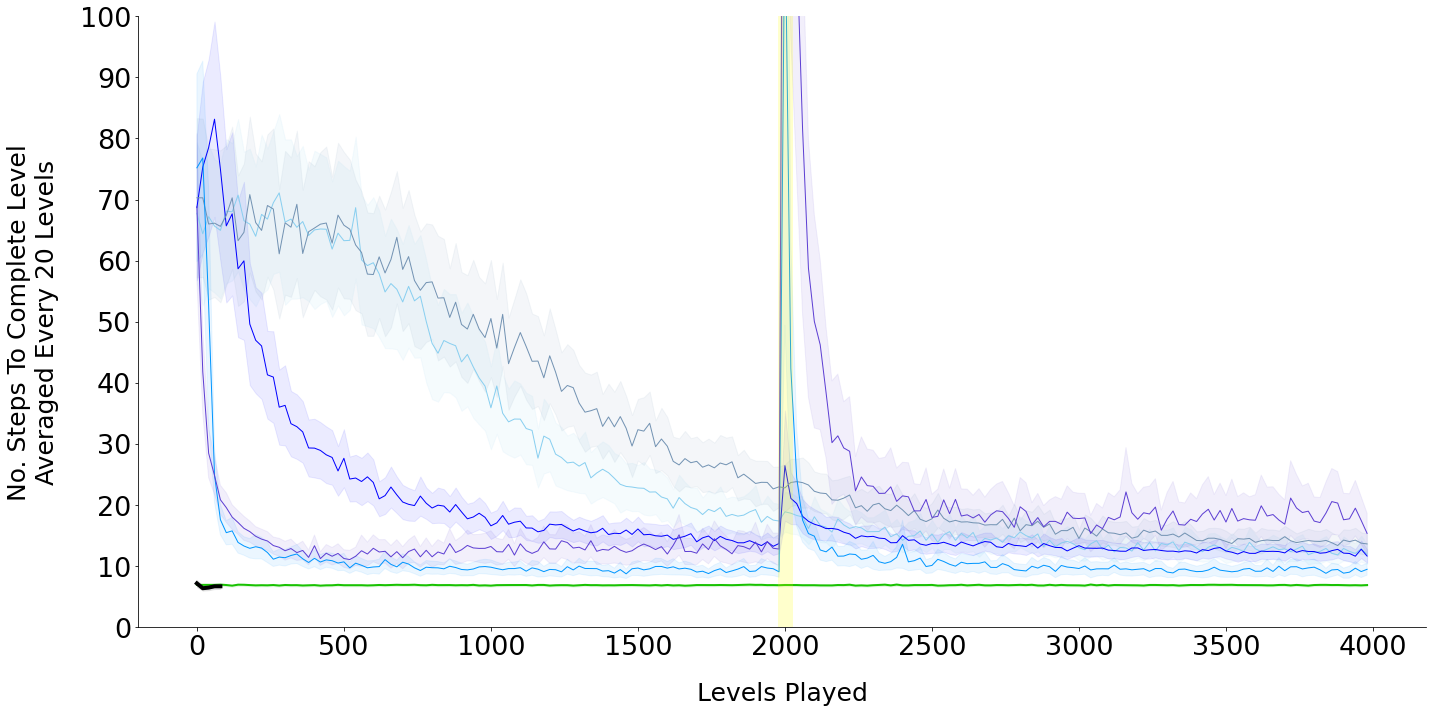

In [5]:
game_types = ["logic_game", ] # "logic_game", "contingency_game_shuffled_1", "change_agent_game",
agent_types = ["human", "data_sf", "self_class", "random", "a2c_training", "trpo_training", "acer_training", "ppo2_training", "dqn_training"]
batch_size = 20

for game in game_types:
    # Stress Test
    #if game not in ["logic_game", "contingency_game_shuffled_1"]:
    agents_stress = ["human", "self_class", "a2c_training", "trpo_training", "acer_training", "ppo2_training", "dqn_training"]
    stress_stats = get_performance(game, agents_stress, batch_size, single_seed=False, extended=True)
    plotter(stress_stats, game, agents_stress, batch_size, combined=True)


    # All 2000:
    #stats_dict = get_performance(game, agent_types, batch_size, single_seed=False, extended=False)
    #plotter(stats_dict, game, agent_types, batch_size, combined=False)

    # Last Hundred
    #plotter(stats_dict, game, ["self_class", "a2c_training", "trpo_training", "acer_training", "ppo2_training", "dqn_training"], batch_size, last_100=True)

    # First Hundred
    #if game == 'change_agent_game':
    #    plotter(get_performance(game, ["human", "self_class"], 1, single_seed=False), game, ["human", "self_class"], 1, only_first_100=True)
    #else:
    #    plotter(get_performance(game, ["human", "self_class"], 1, single_seed=False), game, ["human", "self_class"], 1, only_first_100=True)


In [ ]:
# Harder Stress Test for Switching Embodiemnts Game:
agents_stress = ["a2c_training", "trpo_training", "acer_training", "ppo2_training", "dqn_training"]
stress_stats = get_performance('change_agent_game_harder', agents_stress, batch_size, single_seed=False, extended=True)
plotter(stress_stats, 'change_agent_game_harder', agents_stress, batch_size, combined=True)

In [ ]:
## ----- Plot the number of steps the player takes before any agent moves from its starting location

# Plot no-movement action count of agent for each level
def plot_nm_ac(game_types, agent_types, batch_size=20, only_first_100=False):
    for i, game_type in enumerate(game_types):
        nm_ac = get_all_nm_ac(agent_types, game_type, batch_size)

        fig, ax = plt.subplots(figsize=(20, 10))

        ax.xaxis.label.set_size(25)
        ax.yaxis.label.set_size(25)

        if only_first_100:
            ax.set_xlim([0, 100])

        ax.set_xlabel(xlabel="Levels Played", labelpad=21)

        ax.set_ylabel(ylabel="No. Steps Until Self Orienting\nAveraged Every {} Levels".format(batch_size),
                      labelpad=21)
        ax.tick_params(axis='both', which='major', labelsize=30)

        for j, agent in enumerate(agent_types):
            xs = [int(i * batch_size) for i in range(0, len(nm_ac[agent + "_m"]))]
            line_width = 3 if agent == 'human' else 1
            ax.plot(xs, nm_ac[agent + "_m"], color=colors[agent], linewidth=line_width, label=label_dict[agent])
            upper_curve = [nm_ac[agent + '_m'][i] + nm_ac[agent + '_se'][i] for i in
                           range(len(nm_ac[agent + '_m']))]
            lower_curve = [nm_ac[agent + '_m'][i] - nm_ac[agent + '_se'][i] for i in
                           range(len(nm_ac[agent + '_m']))]
            x = [int(i * batch_size) for i in range(0, len(nm_ac[agent + "_m"]))]
            ax.fill_between(x, lower_curve, upper_curve, alpha=0.05, color=colors[agent])

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        #plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize='xx-large')

        fs = 50 if 'contingency_game' in game_type else 25
        fs = 100 if 'contingency_game_shuffled' in game_type else fs

        #leg = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title_fontsize=fs)
        #plt.rc('legend', fontsize=fs)

        #for legobj in leg.legendHandles:
        #    legobj.set_linewidth(6.0)

        plt.tight_layout()

        path = './plots/{}/{}/'.format(game_type, 'curves')
        if not os.path.exists(path):
            os.makedirs(path)

        fig.savefig(path + 'no_movement_action_count_{}{}.pdf'.format(game_type, batch_size), format='pdf')


## Get no-movement action count of agent for each level and each game as a dictionary
def get_all_nm_ac(agent_types, game_type, batch_size):
    # Check if saved data exists
    fpath = './plotting_data/nm_ac_' + game_type + "_batchSize=" + str(batch_size) + ".pickle"
    if exists(fpath):
        return pickle.load(open(fpath, 'rb'))

    stats = {}
    for agent in agent_types:
        stats[agent + "_m"], stats[agent + "_se"] = get_nm_ac(agent, game_type, batch_size)

    # Save data
    with open(fpath, 'wb') as f:
        pickle.dump(stats, f)

    return stats


## Get no-movement action count of agent for each level
def get_nm_ac(agent_type, game_type, batch_size):
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json")

    if len(files) == 0:
        files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

    all_seeds = []
    curr_seed = []
    seed = 0
    curr_file_count = 0
    file_amt = len(files)

    if agent_type not in ["human", "self_class", "random"]:
        files = [x for x in files if int(x.split("/")[-1][6:-5]) <= 1900]

    sorted_files = sorted(files, key=os.path.getmtime if agent_type == 'human' else get_seed_num_and_iter)
    for i, file in enumerate(sorted_files):
        print("Getting... ", file)
        data = json.load(open(file))
        self_locs = data.get("data")["self_locs"]

        level_amt = 100
        action_count = [1] * level_amt

        # In each 100 levels:
        for level in range(level_amt):
            if len(self_locs[level]) == 0:
                continue
            action_amt = len(self_locs[level][0])
            for i in range(action_amt):
                if i == level_amt:
                    break

                x = self_locs[level][0][i]
                y = self_locs[level][1][i]
                x1 = self_locs[level][0][i + 1]
                y1 = self_locs[level][1][i + 1]

                if x == x1 and y == y1:  # Still in the same position
                    action_count[level] = action_count[level] + 1
                else:  # Position have changed
                    break

        curr_file_count += 1
        curr_seed.append(action_count)

        if agent_type == 'human' and (curr_file_count == file_amt or file_amt == 1):
            all_seeds = curr_seed
            break

        if agent_type != 'human' and curr_file_count == 20:
            all_seeds.append(curr_seed)
            curr_seed = []
            curr_file_count = 0
            seed += 1

    all_seeds = pd.DataFrame(all_seeds)

    seed_average = []
    seed_sem = []
    for column in all_seeds:
        seed_average.append(np.mean(list(all_seeds[column]), axis=0))
        seed_sem.append((pd.DataFrame(list(all_seeds[column]))).sem(axis=0))

    curr_avg_data = pd.DataFrame(seed_average).T
    curr_sem_data = pd.DataFrame(seed_sem).T

    if agent_type != 'human':
        seed_mean = np.array(
            [curr_avg_data[column].groupby(curr_avg_data.index // batch_size).mean() for column in
             curr_avg_data]).reshape(
            int(curr_avg_data.shape[1] * 100 * 1 / batch_size))
        s_sem = np.array(
            [curr_sem_data[column].groupby(curr_sem_data.index // batch_size).mean() for column in
             curr_sem_data]).reshape(
            int(curr_sem_data.shape[1] * 100 * 1 / batch_size))
    else:
        temp = np.asarray(curr_avg_data).T
        avg_ma = [temp[i:i + batch_size].mean() for i in range(0, curr_avg_data.shape[1] - batch_size + 1, batch_size)]

        temp = np.asarray(curr_sem_data).T
        avg_se = [temp[i:i + batch_size].mean() for i in range(0, curr_sem_data.shape[1] - batch_size + 1, batch_size)]

        seed_mean = np.array(avg_ma).reshape(int(curr_avg_data.shape[1] / batch_size))
        s_sem = np.array(avg_se).reshape(int(curr_sem_data.shape[1] / batch_size))

    return seed_mean, s_sem

In [ ]:
## Plot Action Counts Without Movement

agent_types = ["human", "self_class", "random", "a2c_training", "trpo_training", "acer_training", "ppo2_training",
               "dqn_training", ]
game_types = ["logic_game"]
plot_nm_ac(game_types, agent_types)

In [ ]:
## ----- Plot average distance from the goal for each level
def plot_avg_distance(game_types, agent_types, batch_size=50, level=1999):
    for i, game_type in enumerate(game_types):
        avg_distance = get_all_avg_distance(agent_types, game_type, batch_size, level)
        xls = [150]
        for xl in xls:
            fig, ax = plt.subplots(figsize=(20, 10))
            ax.set_xlim([0, xl])
            ax.xaxis.label.set_size(25)
            ax.yaxis.label.set_size(25)

            #ax.set_xlabel(xlabel="Step", labelpad=21)
            #ax.set_ylabel(ylabel="Average Distance to Goal", labelpad=21)
            ax.tick_params(axis='both', which='major', labelsize=17)
            ax.xaxis.set_tick_params(labelsize=25)
            ax.yaxis.set_tick_params(labelsize=25)
            #ax.set_title(game_titles[game_type], fontweight='bold', fontsize=25)

            for j, agent in enumerate(agent_types):
                xs = [int(i * batch_size) for i in range(0, len(avg_distance[agent + "_m"]))]
                line_width = 4 if agent == 'human' or agent == 'self_class' else 1
                ax.plot(xs, avg_distance[agent + "_m"], color=colors[agent], linewidth=line_width,
                        label=label_dict[agent])
                upper_curve = [avg_distance[agent + '_m'][i] + avg_distance[agent + '_se'][i] for i in
                               range(len(avg_distance[agent + '_m']))]
                lower_curve = [avg_distance[agent + '_m'][i] - avg_distance[agent + '_se'][i] for i in
                               range(len(avg_distance[agent + '_m']))]
                x = [int(i * batch_size) for i in range(0, len(avg_distance[agent + "_m"]))]
                ax.fill_between(x, lower_curve, upper_curve, alpha=0.08, color=colors[agent])

            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            plt.tight_layout()
            plt.show()

            path = './plots/{}/{}/'.format(game_type, 'curves')
            if not os.path.exists(path):
                os.makedirs(path)

            fig.savefig(path + '{}_distance_{}{}{}.pdf'.format(xl, game_type, batch_size, level), format='pdf')


def get_all_avg_distance(agent_types, game_type, batch_size, level=0):
    # Check if saved data exists
    fpath = './plotting_data/dist_' + game_type + "_batchSize=" + str(batch_size) + "level={}".format(str(level)) + ".pickle"
    if exists(fpath):
        return pickle.load(open(fpath, 'rb'))

    stats = {}
    for agent in agent_types:
        print(agent + "_m")
        stats[agent + "_m"], stats[agent + "_se"] = get_avg_distance(agent, game_type, batch_size, level)

    # Save data
    with open(fpath, 'wb') as f:
        pickle.dump(stats, f)

    return stats

# Ignore batch_size here, as it does not mean anything
def get_avg_distance(agent_type, game_type, batch_size, level=0):
    if batch_size != 1:
        print("Batch size should be 1")
        return
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json")

    if len(files) == 0:
        files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

    all_seeds = []
    curr_file_count = 0

    if agent_type not in ["human", "self_class", "random"]:
        files = [x for x in files if int(x.split("/")[-1][6:-5]) <= 1900]

    sorted_files = sorted(files, key=os.path.getmtime if agent_type == 'human' else get_seed_num_and_iter)

    if agent_type != 'human':
        if level == 1:
            sorted_files = [sorted_files[j] for j in range(0, len(files), 20)]
        elif level == 1999: # Get the files that only contain the last level
            sf = []
            for j in range(0, len(files), 20):
                sf.append(sorted_files[j - 1])
            sorted_files = sf


    file_amt = len(sorted_files)
    level = level % 100

    # For each seed/subject:
    for i, file in enumerate(sorted_files):
        print("Getting... ", file)
        data = json.load(open(file))
        self_locs = data.get("data")["self_locs"]

        #level_amt = 100
        action_amt = len(self_locs[level][0])

        # Store distance to goal at every action for a particular seed
        distances = [0 for y in range(action_amt)]

        if len(self_locs[level]) == 0:
            continue

        # In each action:
        for action_index in range(action_amt):
            x = self_locs[level][0][action_index]
            y = self_locs[level][1][action_index]

            distances[action_index] = abs(x - 10) + abs(y - 10)

        curr_file_count += 1
        all_seeds.append(distances)

    all_seeds = pd.DataFrame(all_seeds).fillna(0)

    if agent_type == 'human':
        all_seeds.insert(loc=0, value=pd.DataFrame([8 for i in range(file_amt)]), column=-1)  # Set starting distance (8)

    seed_average = []
    seed_sem = []
    for column in all_seeds:
        seed_average.append(np.mean(list(all_seeds[column]), axis=0))
        seed_sem.append((pd.DataFrame(list(all_seeds[column]))).sem(axis=0))

    curr_avg_data = pd.DataFrame(seed_average).T
    curr_sem_data = pd.DataFrame(seed_sem).T

    if agent_type != 'human':  # AI
        seed_mean = np.array(
            [curr_avg_data[column].groupby(curr_avg_data.index // batch_size).mean() for column in
             curr_avg_data]).reshape(
            int(curr_avg_data.shape[1] * 1 / batch_size))
        s_sem = np.array(
            [curr_sem_data[column].groupby(curr_sem_data.index // batch_size).mean() for column in
             curr_sem_data]).reshape(
            int(curr_sem_data.shape[1] * 1 / batch_size))
    else:
        temp = np.asarray(curr_avg_data).T
        avg_ma = [temp[i:i + batch_size].mean() for i in range(0, curr_avg_data.shape[1] - batch_size + 1, batch_size)]

        temp = np.asarray(curr_sem_data).T
        avg_se = [temp[i:i + batch_size].mean() for i in range(0, curr_sem_data.shape[1] - batch_size + 1, batch_size)]

        seed_mean = np.array(avg_ma).reshape(int(curr_avg_data.shape[1] / batch_size))
        s_sem = np.array(avg_se).reshape(int(curr_sem_data.shape[1] / batch_size))

    return seed_mean, s_sem

In [ ]:
agent_types = ["human", "self_class", "random", "a2c_training", "trpo_training", "acer_training", "ppo2_training",
               "dqn_training", ]
game_types = ["change_agent_game",] #"contingency_game_shuffled_1"] #, "contingency_game", "change_agent_game", "contingency_game_shuffled_100", "contingency_game_shuffled_200"
plot_avg_distance(game_types, agent_types, batch_size=1, level=1)
plot_avg_distance(game_types, agent_types, batch_size=1, level=1999)

In [ ]:
##### Plot self finding steps in contingency game for each level #####

def plot_self_finding(game_type):
    means, ses = get_self_finding_steps(game_type)

    fig, ax = plt.subplots(figsize=(20, 10))

    ax.xaxis.label.set_size(25)
    ax.yaxis.label.set_size(25)

    ax.set_xlabel(xlabel="Levels Played", labelpad=21)

    ax.set_ylabel(ylabel="No. Steps Until Self Orienting",
                  labelpad=21)
    ax.set_ylim([0, 10])

    if game_type == 'contingency_game_shuffled_1':
        ax.set_ylim([0, 50])

    ax.tick_params(axis='both', which='major', labelsize=30)

    xs = [int(i) for i in range(0, len(means))]
    line_width = 3
    ax.plot(xs, means, color=colors['human'], linewidth=3, label=label_dict['human'])
    upper_curve = [means[i] + ses[i] for i in
                   range(len(means))]
    lower_curve = [means[i] - ses[i] for i in
                   range(len(means))]

    ax.fill_between(xs, lower_curve, upper_curve, alpha=0.05, color=colors['human'])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.tight_layout()

    path = './plots/{}/{}/'.format(game_type, 'curves')
    if not os.path.exists(path):
        os.makedirs(path)

    fig.savefig(path + 'self_finding_' + game_type + '.pdf', format='pdf')


## Get no-movement action count of agent for each level
def get_self_finding_steps(game_type):
    files = glob.glob("../data/" + game_type + "/data_sf/*.json")

    file_amt = len(files)
    level_means = []
    level_ses = []

    for level in range(0, 100):  # Data for each level
        curr_lvl = []
        for i, file in enumerate(files):  # Get the data for each participant in that level
            data = json.load(open(file))
            selected_agents = data.get("selectedAgents")

            # Find the current level
            c_level = [d for d in selected_agents if d['level'] == level and d['real_self'] == d['clicked_self']]
            if len(c_level) == 1:
                #if level > 5 and c_level[0]['step'] > 20:
                #    print("Level: {} -- Step: {} -- File: {}".format(str(level), str(c_level[0]['step']), file))
                curr_lvl.append(c_level[0]['step'])

        level_means.append(statistics.mean(curr_lvl))
        level_ses.append(sem(curr_lvl))

    df = pd.DataFrame({'level_means': level_means})
    df.to_csv('../stats/self_orienting_{}.csv'.format(game_type))

    return level_means, level_ses

In [ ]:
# Is there correlation between no. steps until self orienting and number of steps taken to finish level?

In [ ]:
#plot_self_finding("contingency_game")
plot_self_finding("contingency_game_shuffled_1")